# Logistic regression model
Goal is to make a binary classification model for a single charging spot, in this case can predict when spot 02 will be available of the office01 site

1st model, assume each time point is independent



## 0 imports

In [1]:
import os
if 'models' == os.getcwd().split('/')[-1]: os.chdir('..')
if 'ev_charging' == os.getcwd().split('/')[-1]: print('in the right place!')
else: os.chdir('/Users/varunvenkatesh/Documents/Github/ev_charging')
os.getcwd()

in the right place!


'/home/denny/Documents/mids/ev_charging'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data_preprocessing import datetime_processing, userinput_processing, holiday_processing, get_start_end_times, create_wide_y, create_all_site_y, create_x

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score


## 1 Data and Cleaning

In [3]:
# load office data

In [4]:
df_of = pd.read_parquet('data/ACN-API/office001/').reset_index(drop=True)
df_of = datetime_processing(df_of)
df_of = userinput_processing(df_of)


In [5]:
df_of.head()

,_id,userID,sessionID,stationID,spaceID,siteID,clusterID,connectionTime,disconnectTime,kWhDelivered,...,doneChargingTimeHour,doneChargingTimeDay,userID,milesRequested,WhPerMile,minutesAvailable,modifiedAt,paymentRequired,requestedDeparture,kWhRequested
0,5cd1d47af9af8b68f0e96713,None,19_102_260_1633_2019-03-25 16:24:42.408146,19-102-260-1633,02,19,102,2019-03-25 16:24:42+00:00,2019-03-26 01:32:12+00:00,6.146,...,17.0,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN
1,5cd1d47af9af8b68f0e96714,None,19_102_260_1634_2019-03-25 17:19:26.896309,19-102-260-1634,03,19,102,2019-03-25 17:19:27+00:00,2019-03-26 00:38:50+00:00,3.658,...,18.0,25.0,NaN,NaN,NaN,NaN,None,None,None,NaN
2,5cd1d47af9af8b68f0e96715,None,19_102_260_1640_2019-03-25 21:27:32.338192,19-102-260-1640,08,19,102,2019-03-25 21:27:32+00:00,2019-03-26 03:32:03+00:00,28.330,...,2.0,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN
3,5cd1d47df9af8b68f0e96716,None,19_102_260_1640_2019-03-26 18:33:56.204855,19-102-260-1640,08,19,102,2019-03-26 18:33:56+00:00,2019-03-27 00:45:33+00:00,12.978,...,22.0,26.0,NaN,NaN,NaN,NaN,None,None,None,NaN
4,5cd1d47ef9af8b68f0e96717,None,19_102_260_1640_2019-03-27 18:28:00.642220,19-102-260-1640,08,19,102,2019-03-27 18:28:01+00:00,2019-03-28 00:37:47+00:00,10.688,...,21.0,27.0,NaN,NaN,NaN,NaN,None,None,None,NaN


In [6]:
df_of.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681 entries, 0 to 1680
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   _id                   1681 non-null   object             
 1   userID                583 non-null    object             
 2   sessionID             1681 non-null   object             
 3   stationID             1681 non-null   object             
 4   spaceID               1681 non-null   object             
 5   siteID                1681 non-null   int64              
 6   clusterID             1681 non-null   int64              
 7   connectionTime        1681 non-null   datetime64[ns, UTC]
 8   disconnectTime        1681 non-null   datetime64[ns, UTC]
 9   kWhDelivered          1681 non-null   float64            
 10  doneChargingTime      1627 non-null   datetime64[ns, UTC]
 11  connectionTimeHour    1681 non-null   int32              
 12  connec

## 2 plotting and eval

In [7]:
def make_classification_plot(cm):
    disp = ConfusionMatrixDisplay(cm)
    disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    plt.grid(False)
    plt.show()

In [8]:
def get_results(y_test, prediction):
    cm = confusion_matrix(y_test,prediction)
    make_classification_plot(cm)
    
    results = {'tpr': cm[1, 1]/np.sum(cm[1]),
               'fpr': cm[0,1]/np.sum(cm[0]),
               'accuracy': accuracy_score(y_test, prediction),
               'precision': precision_score(y_test, prediction),
               'recall': recall_score(y_test, prediction),
        'f1':f1_score(y_test,prediction)}
    return results
    

In [9]:
results = {}

# 3 Make X and y values

In [10]:
space_ = '02'
df = df_of[df_of['spaceID'] == '02']
start_date, end_date = get_start_end_times(df)
y = create_all_site_y(df, regression=False).rename(columns={space_:'is_available'})

# convert to series
y = y['is_available']

In [11]:
# tmp = df_of.copy().set_index('connectionTime')
# tmp = tmp[tmp['spaceID'] == '02'].sort_index()

In [12]:
# # TODO: make better variable names ie start_ -> session_start_time
# y = pd.DataFrame(index=pd.date_range('2019-03-25','2021-09-12', inclusive='both', freq='h', tz=0),columns=['is_available','sessionID'])
# y['is_available'] = 1
# for i in range(len(tmp)):
#     start_ = tmp.index[i]
#     end_ = tmp.loc[start_,'disconnectTime'] 
#     session_ = tmp.loc[start_,'sessionID']
#     # print(start_,'\t', end_,'\t', session_)
#     y.loc[start_:end_,['is_available','sessionID']] = 0, session_

In [13]:
# y = y['is_available']

In [14]:
X = create_x(start_date, end_date, caiso_fp=False)

In [15]:
# X = pd.DataFrame(index=pd.date_range('2019-03-25','2021-09-12', inclusive='both', freq='h', tz=0),columns=['dow','hour','month'])
# # X['dow'] = X.index.dt.hour
# X['dow'] = X.index.dayofweek
# X['hour'] = X.index.hour
# X['month'] = X.index.month
# X['connectionTime'] = X.index
# X = holiday_processing(X).drop(columns=['connectionTime'])
# X.head()

In [16]:
# print(f'charger spot #2 is available {np.round(y.is_available.mean()*100,3)}% of the time')
print(f'charger spot #2 is available {np.round(y.mean()*100,3)}% of the time')

charger spot #2 is available 89.274% of the time


In [17]:
X.shape[0] == y.shape[0]

True

# 4 model time

## using a stratified train test split as often as possible
https://www.investopedia.com/terms/stratified_random_sampling.asp

In [19]:
# Create hold out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify=y)
print(f'the training data has an average availability of {np.round(y_train.mean()*100,3)}%')


the training data has an average availability of 89.271%


## 4.1 Baselines

### 4.10 Guess always available (baseline)

guess always available and never available


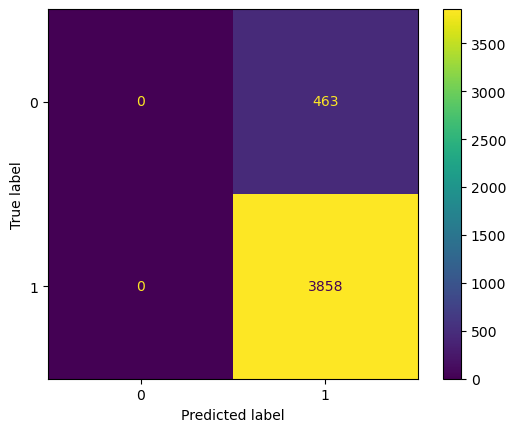

In [20]:
print('guess always available and never available')
results['always_available'] = get_results(y_test, [1] * len(y_test))


### 4.11 Guess never available (baseline)

guess never available


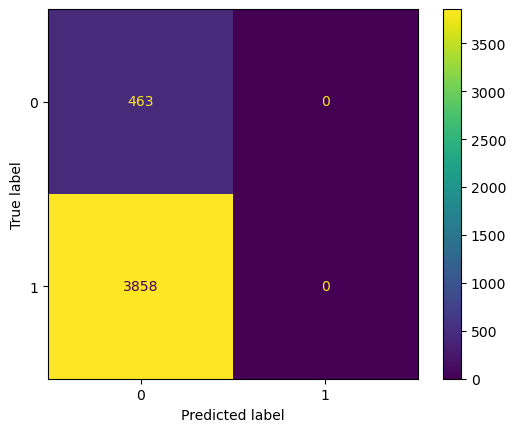

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
print('guess never available') 
results['never_available'] = get_results(y_test, [0] * len(y_test))

## 4.2 Sklearn logistic regression models

## 4.21 L2 penalty

The average accuracy is 0.893 ± 0.001
test accuracy is 0.8926174496644296


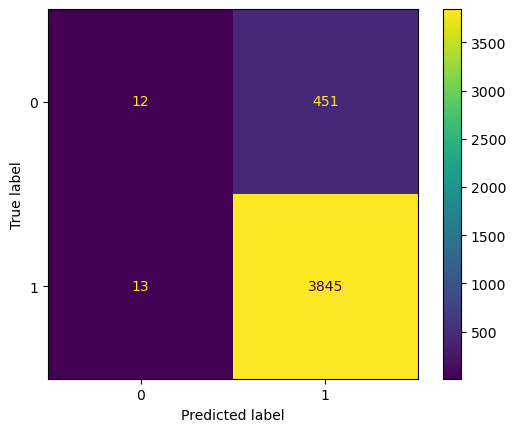

In [22]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


model = LogisticRegression(penalty='l2')
pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')),
    ('lr', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_l2_skf'] = get_results(y_test, pred)


In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X_train, y_train, cv=skf)

array([0.8921875 , 0.89392361, 0.89253472])

In [24]:
# standard error for the model

In [25]:
# https://stackoverflow.com/questions/22381497/python-scikit-learn-linear-model-parameter-standard-error
N = len(X_train)
p = len(pipe[0].get_feature_names_out()) + 1  # plus one because LinearRegression adds an intercept term
print('X shape :', N,p)
X_with_intercept = np.empty(shape=(N, p), dtype='float')
X_with_intercept[:, 0] = 1
X_with_intercept[:, 1:p] = pipe[0].transform(X_train)# ohe.transform(X_train)
beta_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y_train.values
coefs_intercept = np.concatenate((pipe[1].intercept_, pipe[1].coef_.reshape(-1)))
beta_hat = beta_hat.reshape(-1)
assert beta_hat.shape == coefs_intercept.shape, f'the shapes dont match for beta_hat and coefs intercept\n{beta_hat.shape} != {coefs_intercept.shape}'
col_names = ['intercept'] + list(pipe[:-1].get_feature_names_out())
pd.DataFrame(data=np.concatenate([[coefs_intercept], [beta_hat]]),
             columns=['intercept'] + list(pipe[:-1].get_feature_names_out())).T.reset_index().rename(columns={0:'estimation',1:'standard_error','index':'coefficient'})

X shape : 17280 42


,coefficient,estimation,standard_error
0,intercept,1.274228,0.757073
1,dow_1,-0.183464,-0.015384
2,dow_2,-0.341636,-0.031223
3,dow_3,-0.344232,-0.031133
4,dow_4,-0.403077,-0.036453
5,dow_5,1.778714,0.098488
6,dow_6,4.582491,0.124161
7,hour_1,0.120978,0.059440
8,hour_2,0.868163,0.125020
9,hour_3,2.143759,0.178268


## 4.22 L1 penalty

The average accuracy is 0.893 ± 0.001
test accuracy is 0.8930803054848415


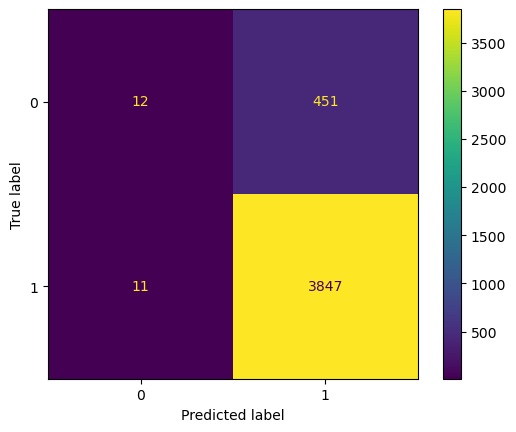

In [26]:
model = LogisticRegression(penalty='l1', solver='liblinear')
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('lrl1', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_reg_l1_skf'] = get_results(y_test, pred)


In [27]:
print(pipe[-1].coef_.shape)
pipe[-1].n_features_in_
pipe[-1].intercept_
pipe[-1].classes_
pd.DataFrame(pipe[-1].coef_, columns=pipe[:-1].get_feature_names_out()).T
# ?pipe[-1]
# pipe[:-1].get_feature_names_out()

(1, 45)


,0
dow_0,0.331930
dow_1,0.153904
dow_2,0.000000
dow_3,-0.001335
dow_4,-0.048620
dow_5,2.145914
dow_6,6.384804
hour_0,-1.360168
hour_1,-0.874617
hour_2,-0.112905


In [28]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
# X, y = datasets.make_classification(n_classes=2, random_state=0)
# svm = LinearSVC(dual="auto", random_state=0)
lr = LogisticRegression(penalty="l2")
def confusion_matrix_scorer(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return {'tn': cm[0, 0], 'fp': cm[0, 1],
             'fn': cm[1, 0], 'tp': cm[1, 1]}
cv_results = cross_validate(lr, X_train, y_train, cv=5,
                            scoring=confusion_matrix_scorer)
# Getting the test set true positive scores
print(cv_results['test_tp'])
# Getting the test set false negative scores
print(cv_results['test_fn'])

[3086 3085 3085 3085 3085]
[0 0 0 0 0]


## 4.23 elastic net penalty

# TO DO: use gridsearch to find best l1 ratio

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


The average accuracy is 0.893 ± 0.001
test accuracy is 0.8930803054848415


/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


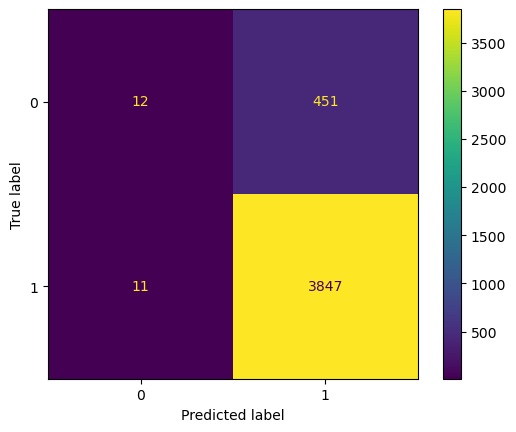

In [29]:
model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.1)
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('lrl1', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_log_elasticnet_skf'] = get_results(y_test, pred)

## 4.3 Sklearn Random Forrest Classifier

The average accuracy is 0.870 ± 0.000
test accuracy is 0.8789632029622773


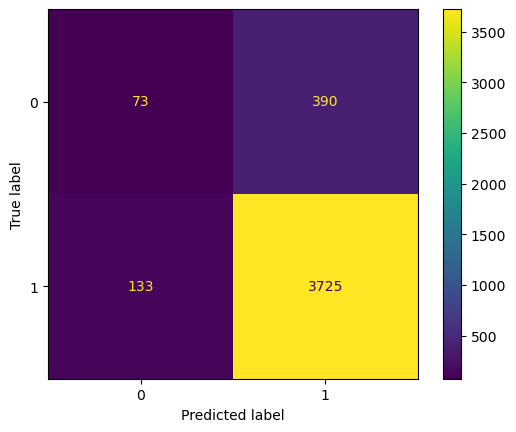

In [30]:
# tree models
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
pipe = Pipeline([
    ('ohe', OneHotEncoder()),
    ('rf', model),
])

skf = StratifiedKFold(n_splits=3)
cv_results = cross_validate(pipe, X_train, y_train, cv=skf)
test_score = cv_results["test_score"]
print(
    f"The average accuracy is {test_score.mean():.3f} ± {test_score.std():.3f}"
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)
print(f'test accuracy is {pipe.score(X_test, y_test)}')

results['sk_rf_classification_skf'] = get_results(y_test, pred)


# 4.4 stats model version

In [31]:
# ! pip install statsmodels

In [32]:
import statsmodels.api as sm 
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index)

,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
2019-03-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
2019-03-25 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-09-09 20:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0
2021-09-09 21:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0
2021-09-09 22:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0
2021-09-09 23:00:00+00:00,0.0,0.0,1.0,0.0,0.0,0.0


In [33]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
ohe.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 

         Current function value: 0.360834
         Iterations: 35


/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X[['dow']])
ohe.transform(X[['dow']])
ohe.get_feature_names_out()
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['dow']]), columns=ohe.get_feature_names_out(), index=X.index),#.drop(columns=ohe.get_feature_names_out()[0:3]), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())

         Current function value: inf
         Iterations: 35


/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


LinAlgError: Singular matrix

In [35]:
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17280
Model:                          Logit   Df Residuals:                    17274
Method:                           MLE   Df Model:                            5
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                -0.05874
Time:                        22:38:38   Log-Likelihood:                -6235.2
converged:                      False   LL-Null:                       -5889.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dow_1          1.8480      0.059     31.532      0.000       1.733       1.963
dow_2          1.7019      0.056     30.591      0.000       1.593       1.811
dow_3          1.6212      0.054     29.849      0.0

In [36]:
y_hat = log_reg.predict(X_test)
prediction = list(map(round, y_hat))
# confusion matrix 
cm = confusion_matrix(y_test, prediction)  
print ("Confusion Matrix : \n", cm)  
  
# accuracy score of the model 
print('Test accuracy = ', accuracy_score(y_test, prediction))

ValueError: shapes (4321,7) and (6,) not aligned: 7 (dim 1) != 6 (dim 0)

In [37]:
results['sm_log_reg_dow_skf'] = get_results(y_test, prediction)

NameError: name 'prediction' is not defined

In [38]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['hour']])
ohe.transform(X[['hour']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.269796
         Iterations 11


In [39]:
print(log_reg.summary()) 

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17280
Model:                          Logit   Df Residuals:                    17257
Method:                           MLE   Df Model:                           22
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                  0.2084
Time:                        22:38:40   Log-Likelihood:                -4662.1
converged:                       True   LL-Null:                       -5889.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hour_1         1.8616      0.108     17.232      0.000       1.650       2.073
hour_2         2.4132      0.136     17.758      0.000       2.147       2.680
hour_3         4.0003      0.280     14.293      0.0

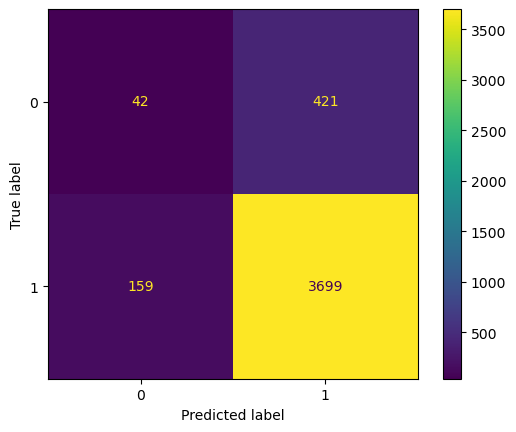

In [40]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_hour_sfk'] = get_results(y_test, prediction)

In [41]:
X_train

,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
2019-10-05 18:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-09-02 09:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 15:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-14 19:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-07-11 16:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01 02:00:00+00:00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-19 10:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-09 20:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2020-08-08 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# not weekend, the log odds is 1.782
# for the weekend, the log odds increases 2.3780, to 4.1606
y_train[X_train.hour_18==True]
# probability of ytrain
print('for not 6 PM...')
p_success = y_train[X_train.hour_18==False].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
p_not6pm = p_success
print('\n\nfor 6 PM,')
p_success = y_train[X_train.hour_18==True].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
print(f'\n\nthe probaility of availability changes from {p_success} to {p_not6pm}, a difference of {np.round((p_success-p_not6pm)/p_not6pm*100,3)}%')

for not 6 PM...
prob of success 0.899837084414409
prob of failure 0.10016291558559098
odds of success 8.98373493975904
log odds of success 2.195415713412194


for 6 PM,
prob of success 0.7256011315417256
prob of failure 0.27439886845827444
odds of success 2.644329896907216
log odds of success 0.9724176861074412


the probaility of availability changes from 0.7256011315417256 to 0.899837084414409, a difference of -19.363%


In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.21      0.09      0.13       463
           1       0.90      0.96      0.93      3858

    accuracy                           0.87      4321
   macro avg       0.55      0.52      0.53      4321
weighted avg       0.82      0.87      0.84      4321


In [44]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['month','hour']])
ohe.transform(X[['month','hour']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['month','hour']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.261538
         Iterations 10


In [45]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17280
Model:                          Logit   Df Residuals:                    17246
Method:                           MLE   Df Model:                           33
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                  0.2326
Time:                        22:38:42   Log-Likelihood:                -4519.4
converged:                       True   LL-Null:                       -5889.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_2        0.7336      0.117      6.247      0.000       0.503       0.964
month_3        0.3927      0.104      3.765      0.000       0.188       0.597
month_4        0.9470      0.104      9.126      0.0

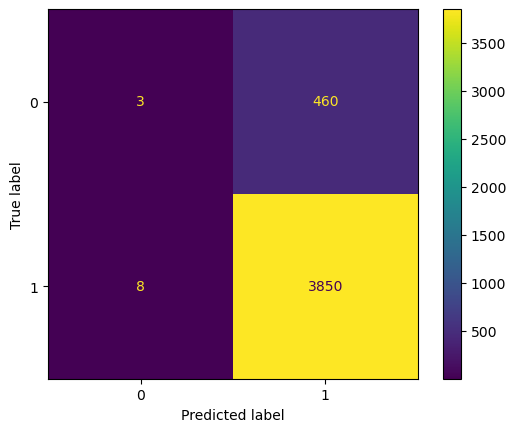

In [46]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_month_hour_skf'] = get_results(y_test, prediction)


In [47]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X)
ohe.transform(X)
ohe.get_feature_names_out()[0]

X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X), columns=ohe.get_feature_names_out(), index=X.index), #.drop(columns=ohe.get_feature_names_out()[0]), 
    y, 
    test_size=.2, 
    stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['hour']]), columns=ohe.get_feature_names_out(), index=X.index), y['is_available'])
log_reg = sm.Logit(y_train, X_train).fit() 
print(log_reg.summary())

         Current function value: 0.228638
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17280
Model:                          Logit   Df Residuals:                    17239
Method:                           MLE   Df Model:                           40
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                  0.3291
Time:                        22:38:43   Log-Likelihood:                -3950.9
converged:                      False   LL-Null:                       -5889.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
dow_1              -0.0541      0.088     -0.616      0.538      -0.226       0.118
dow_2              -0.1715      0.087     -1.966  

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


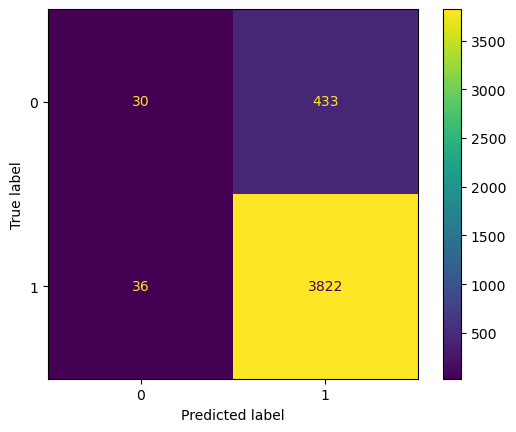

In [48]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
results['sm_month_hour_dow_skf'] = get_results(y_test, prediction)

guess always available and never available


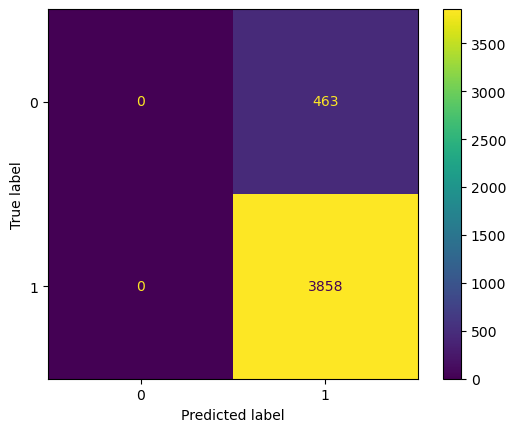

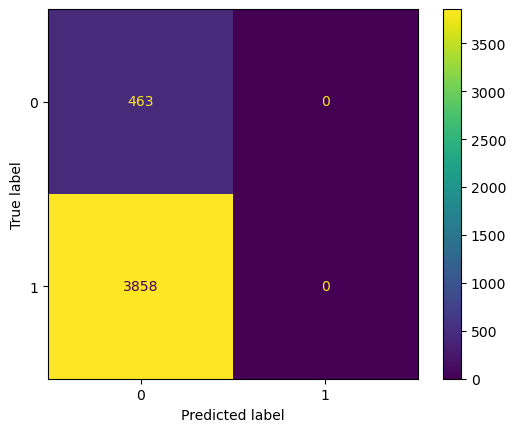

/home/denny/anaconda3/envs/ev/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
print('guess always available and never available')
results['always_available'] =  get_results(y_test, [1]*len(y_test))
results['never_available'] =  get_results(y_test, [0]*len(y_test))


In [50]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['month']])
ohe.transform(X[['month']])
X_train, X_test, y_train, y_test = train_test_split(
    pd.DataFrame(ohe.transform(X[['month']]), columns=ohe.get_feature_names_out(), index=X.index), 
    y, 
    test_size=.2, 
    stratify=y)
log_reg = sm.Logit(y_train, X_train).fit() 

Optimization terminated successfully.
         Current function value: 0.360741
         Iterations 6


In [51]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17280
Model:                          Logit   Df Residuals:                    17269
Method:                           MLE   Df Model:                           10
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                -0.05847
Time:                        22:38:44   Log-Likelihood:                -6233.6
converged:                       True   LL-Null:                       -5889.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
month_2        2.0393      0.094     21.618      0.000       1.854       2.224
month_3        1.7115      0.077     22.332      0.000       1.561       1.862
month_4        2.1417      0.078     27.407      0.0

In [52]:
yhat = log_reg.predict(X_test) 
prediction = list(map(round, yhat))
yhat

2021-05-30 22:00:00+00:00    0.920225
2019-11-08 17:00:00+00:00    0.910883
2019-11-18 11:00:00+00:00    0.910883
2019-10-23 10:00:00+00:00    0.870339
2020-08-31 11:00:00+00:00    0.897925
                               ...   
2020-09-04 20:00:00+00:00    0.891141
2021-05-26 22:00:00+00:00    0.920225
2021-07-27 11:00:00+00:00    0.894562
2019-11-23 02:00:00+00:00    0.910883
2020-04-26 23:00:00+00:00    0.894888
Length: 4321, dtype: float64

In [53]:
print(classification_report(y_test, prediction))
confusion_matrix(y_test, prediction)


              precision    recall  f1-score   support

           0       0.16      0.10      0.12       463
           1       0.90      0.94      0.92      3858

    accuracy                           0.85      4321
   macro avg       0.53      0.52      0.52      4321
weighted avg       0.82      0.85      0.83      4321


array([[  45,  418],
       [ 236, 3622]])

In [54]:
from sklearn.metrics import  f1_score, precision_score, recall_score
print(f'Precision: out of all the times the model predicted the charger would be available, {np.round(precision_score(y_test, prediction)*100,3)}% of the time it actually was available')
print(f'Recall: out of all the times the charger was available, the model predicted the outcome correctly for {np.round(recall_score(y_test, prediction)*100,3)}% of those times')
print(f'F1 score: the precision recall balance of the model was {np.round(f1_score(y_test,prediction),3)}')
print(f'support available:   {np.sum(y_test==1)}')
print(f'support unavailable: {np.sum(y_test==0)}')


Precision: out of all the times the model predicted the charger would be available, 89.653% of the time it actually was available
Recall: out of all the times the charger was available, the model predicted the outcome correctly for 93.883% of those times
F1 score: the precision recall balance of the model was 0.917
support available:   3858
support unavailable: 463


In [55]:
pd.DataFrame(results).T

,tpr,fpr,accuracy,precision,recall,f1
always_available,1.000000,1.000000,0.892849,0.892849,1.000000,0.943392
never_available,0.000000,0.000000,0.107151,0.000000,0.000000,0.000000
sk_log_l2_skf,0.996630,0.974082,0.892617,0.895019,0.996630,0.943095
sk_log_reg_l1_skf,0.997149,0.974082,0.893080,0.895067,0.997149,0.943355
sk_log_elasticnet_skf,0.997149,0.974082,0.893080,0.895067,0.997149,0.943355
sk_rf_classification_skf,0.965526,0.842333,0.878963,0.905225,0.965526,0.934404
sm_hour_sfk,0.958787,0.909287,0.865772,0.897816,0.958787,0.927300
sm_month_hour_skf,0.997926,0.993521,0.891692,0.893271,0.997926,0.942703
sm_month_hour_dow_skf,0.990669,0.935205,0.891460,0.898237,0.990669,0.942192


# Interpreting model coefficients

In [56]:
# probability of ytrain
p_success = y_train.mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')

prob of success 0.8927083333333333
prob of failure 0.10729166666666667
odds of success 8.320388349514563
log odds of success 2.118708930368144


In [57]:
dummy_1 = pd.DataFrame([1]*len(y_train), columns=['intercept'], index=y_train.index)
int_model = sm.Logit(y_train, dummy_1).fit()

Optimization terminated successfully.
         Current function value: 0.340815
         Iterations 6


In [58]:
print(int_model.summary())

                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                17280
Model:                          Logit   Df Residuals:                    17279
Method:                           MLE   Df Model:                            0
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:               6.453e-11
Time:                        22:38:49   Log-Likelihood:                -5889.3
converged:                       True   LL-Null:                       -5889.3
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1187      0.025     86.195      0.000       2.071       2.167


In [59]:
print(f'the model intercept term is {int_model.params.iloc[0]} which is the same as the log odds of the training set {log_odds}')

the model intercept term is 2.118708930368144 which is the same as the log odds of the training set 2.118708930368144


# new model

In [60]:
X['is_weekend'] = X['dow'].isin([5,6])
X

,dow,hour,month,is_holiday,is_weekend
2019-03-25 00:00:00+00:00,0,0,3,False,False
2019-03-25 01:00:00+00:00,0,1,3,False,False
2019-03-25 02:00:00+00:00,0,2,3,False,False
2019-03-25 03:00:00+00:00,0,3,3,False,False
2019-03-25 04:00:00+00:00,0,4,3,False,False
...,...,...,...,...,...
2021-09-09 20:00:00+00:00,3,20,9,False,False
2021-09-09 21:00:00+00:00,3,21,9,False,False
2021-09-09 22:00:00+00:00,3,22,9,False,False
2021-09-09 23:00:00+00:00,3,23,9,False,False


In [61]:
ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe.fit(X[['is_weekend']])
ohe.transform(X[['is_weekend']])
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(ohe.transform(X[['is_weekend']]), columns=ohe.get_feature_names_out(), index=X.index), y)
log_reg = sm.Logit(y_train, sm.add_constant(X_train)).fit() 
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.314847
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:           is_available   No. Observations:                16200
Model:                          Logit   Df Residuals:                    16198
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Mar 2024   Pseudo R-squ.:                 0.07294
Time:                        22:38:51   Log-Likelihood:                -5100.5
converged:                       True   LL-Null:                       -5501.8
Covariance Type:            nonrobust   LLR p-value:                1.432e-176
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.7860      0.026     67.542      0.000       1.734       1.838
is_weekend_Tru

$logit(p/1-p) = \beta_0 + \beta_1*is_weekend$

In [62]:
# not weekend, the log odds is 1.782
# for the weekend, the log odds increases 2.3780, to 4.1606
y_train[X_train.is_weekend_True==True]
# probability of ytrain
print('for weekdays...')
p_success = y_train[X_train.is_weekend_True==False].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
p_notweekend=p_success
print('\n\nfor weekends,')
p_success = y_train[X_train.is_weekend_True==True].mean()
p_failure = 1- p_success
odds = p_success/p_failure
log_odds = np.log(odds)
print(f'prob of success {p_success}\nprob of failure {p_failure}\nodds of success {odds}\nlog odds of success {log_odds}')
print(f'\n\nthe probaility of availability changes from {p_success} to {p_notweekend}, a difference of {np.round((p_success-p_notweekend)/p_notweekend*100,3)}%')

for weekdays...
prob of success 0.8564305364511692
prob of failure 0.14356946354883082
odds of success 5.965269461077844
log odds of success 1.7859542282224279


for weekends,
prob of success 0.9870840630472855
prob of failure 0.012915936952714535
odds of success 76.42372881355932
log odds of success 4.336293234515365


the probaility of availability changes from 0.9870840630472855 to 0.8564305364511692, a difference of 15.256%


In [63]:
?log_reg
lowt = log_reg.params.iloc[0] + log_reg.params.iloc[1]
lowf = log_reg.params.iloc[0]
prwt = np.exp(lowt)/(1+np.exp(lowt))
prwf = np.exp(lowf)/(1+np.exp(lowf))
print(f'probability of weekend availability {prwt}\nprobability of weekday availability {prwf}')

probability of weekend availability 0.9870840630472855
probability of weekday availability 0.8564305364511692


In [64]:
# weekend add 2.4 to the log odds of availability
# p  exp(beta X)/ 1+ exp(beta X)
# the weekend makes spot availability 2.4 times more likely to occur
# the odds of is availability change by exp(2.49) time for c unit increase in x
np.exp(2.493)

12.097514278865066

In [65]:
print(f'the change in log odds of the day being a weekend is {2.493}')
print(f'that means that the change in odds is {np.exp(2.493)}')

the change in log odds of the day being a weekend is 2.493
that means that the change in odds is 12.097514278865066


In [66]:
is_weekend = 0
P_non_weekend = np.exp(1.7667 + 2.4931 * is_weekend)/(1+np.exp(1.7667 + 2.4931 * is_weekend))
is_weekend = 1
P_weekend = np.exp(1.7667 + 2.4931 * is_weekend)/(1+np.exp(1.7667 + 2.4931 * is_weekend))
print(np.round(P_non_weekend,3), np.round(P_weekend, 3))


0.854 0.986


In [67]:
np.exp(5.2057)/(1+np.exp(5.2057))

0.9945447139365461